In [60]:
from matplotlib import pyplot as plt
import numpy as np
import copy
class daisy():
    def __init__(self,color, total, cov):
        #Standard constants
        self.D = 0.3
        self.ALB = 0.75 if color == 'white' else 0.25
        self.INSUL = 0.2
        self.temp = 0 #TEMPORARY
        self.growth = 0 #TEMPORARY
        self.cov = cov #the first cov is set by us
        
        self.d_growth = 0
        self.d_death = 0
        
        self.total = total #this is used to update coverage because it is now dependent on more factors
        self.color = -1 if color == 'white' else 1 #This is for data plotting
        
        
        self.potential_coords = [] #This is for Conway's implementation
        self.death_row = [] #this is for life_death
        self.coords = []
        
    def d_temp(self, lumin, INSOL, SB, p_alb, p_temp4):
        self.temp = ((self.INSUL * lumin) * \
        (INSOL/SB) * (p_alb - self.ALB) + p_temp4) ** (1/4)
        
    def growth_r(self):
        self.growth = 1 - 0.003265 * ((295.65 - self.temp)**2)
        #print("growth rate is:" + str(self.growth))
    
    def get_growth(self, g_cov, dt):
        #This gives me an ABSOLUTE value
        self.d_growth =  int(self.cov * self.total * g_cov * self.growth * dt)
        #print("growth rate is:" + str(self.d_growth))
        
    def get_death(self, dt):
        #This gives me an ABSOLUTE value
        self.d_death = int(self.cov * self.total * self.D * dt)
    
    def d_cov(self):
        return d_growth - d_death
    
    def update_cov(self):
        return self.total / len(self.coords)

In [84]:
class world():

    def __init__(self, total= 10000, b_cov = 0.01, w_cov = 0.01, t = 20, dt = 1, static = True):
        #Default constants
        self.INSOL = 917
        self.SB = 5.670367*1e-8
        self.ALB = 0.5
        self.p_alb = 0 #TEMPORARY
        self.temp4 = 22.5+273.15 #TEMPORARY
        self.lumin = [1 for i in range(int(t/dt))] if static==True else list(np.linspace(0.5,1.6,int(t/dt)))

        self.total = total
        self.t = t
        self.dt = dt
        self.cov = 0 #TEMPORARY
        self.min_number = 10 #arbitary value
        
        #Data collection
        self.t_lst = list(np.linspace(0,t,int(t/dt)))
        
        self.bdaisy_coll = daisy('black', total, b_cov)
        self.wdaisy_coll = daisy('white', total, w_cov)
        
        #I will have two boards, a daisy board and a temperature board
        grid = int(total**0.5)
        self.d_board = [[0 for i in range(grid)]  for j in range(grid)] #Filling of board will not be done in the initialization step.
        self.t_board = [[0 for i in range(grid)]  for j in range(grid)] #For temperature
        self.n_board = [[[0,0] for i in range(grid)] for j in range(grid)] #For neighbors, can only make with list comprehension due to depth
        
        self.board_hash = {} #This will store all necessary information that I would like in my final output
        
        #Creation of Coordinates
        d_coords = np.random.choice(grid, (int(total*b_cov)+int(total*w_cov),2))
        while True:
            #Checking for duplicates
            d_coords = set(map(tuple,d_coords))
            
            #Making the code less cancerous to read
            no_unique = len(d_coords)
            no_expect = int(total*b_cov)+int(total*w_cov)
            
            if (no_unique == no_expect): #Break when I have no duplicates
                #Converting back to lists and np.arrays
                d_coords = list(map(np.array, d_coords)) 
                break 
                break
            else:
                to_add = np.random.choice(grid, (no_expect-no_unique,2)) #create missing elements
                d_coords = list(map(list,d_coords)) #converting set back to list
                d_coords.extend(to_add) #extending my list to prepare for next operation
                
        #Out of sheer laziness, I will assign the first half to b and the second to white
        d_coords = list(map(list,d_coords))
        self.bdaisy_coll.coords.extend(d_coords[:int(total*b_cov)])
        self.wdaisy_coll.coords.extend(d_coords[int(total*b_cov):])
    
    def ground_cov(self):
        self.cov = 1 - self.bdaisy_coll.cov - self.wdaisy_coll.cov #Establish my ground
    
    def alb(self):
        self.p_alb = (self.bdaisy_coll.cov * self.bdaisy_coll.ALB) + \
        (self.wdaisy_coll.cov * self.wdaisy_coll.ALB) + \
        (self.cov * self.ALB)
    
    def p_temp(self, lumin):
        self.temp4 = lumin * ((self.INSOL/self.SB) * (1 - self.p_alb))
    
    def update_board(self):
        """This method updates both board states with the necessary calculations.
        The daisy board will simply be a show of three basic colors,
        1. Green = Ground, represented by 0
        2. White = White daisies, represented by -1
        3. Black = Black daisies, represented by 1
        The temperature board will simply reflect the temperature values based on Ti
        
        I will use a lazy implementation for neighbor coordinates
        Since we already have collated all their positional coordinates, we can do it the lazy way
        We will just check all 4 surrounding coordinates in black and white daisies and then update the position with a list
        """
        grid = int(self.total**(0.5))
        for row in range(grid):
            for col in range(grid):
                #Updating my d_board and my t_board
                if [row,col] in self.wdaisy_coll.coords: #white daisies
                    self.d_board[row][col] = -1
                    self.t_board[row][col] = self.wdaisy_coll.temp
                if [row,col] in self.bdaisy_coll.coords: #black daisies
                    self.d_board[row][col] = 1
                    self.t_board[row][col] = self.bdaisy_coll.temp
                wdaisy = 0
                bdaisy = 0
                if [row-1,col] in self.wdaisy_coll.coords:
                    wdaisy += 1
                if [row,col-1] in self.wdaisy_coll.coords:
                    wdaisy += 1
                if [row,col+1] in self.wdaisy_coll.coords:
                    wdaisy += 1
                if [row+1,col] in self.wdaisy_coll.coords:
                    wdaisy += 1
                #Perform the exact same operations for black daisies
                if [row-1,col] in self.bdaisy_coll.coords:
                    bdaisy += 1
                if [row,col-1] in self.bdaisy_coll.coords:
                    bdaisy += 1
                if [row,col+1] in self.bdaisy_coll.coords:
                    bdaisy += 1
                if [row+1,col] in self.bdaisy_coll.coords:
                    bdaisy += 1

                #Checking for my edges, if either is at 2, we set them to 4 instead. This implementation will make sense considering life_death
                if (row == 0 and col == 0) or (row == 0 and col == grid-1) or (row == grid-1 and col == 0 ) or (row == grid-1 and col == grid-1):
                    if wdaisy == 2:
                        wdaisy = 4
                    if bdaisy == 2:
                        bdaisy = 4
                #Checking the edges, either one of them needs to be either 0 or grid-1 for it to be an edge:
                elif row == 0 or row == grid-1 or col == 0 or col == grid-1:
                    if wdaisy == 3:
                        wdaisy = 4
                    if bdaisy == 3:
                        bdaisy = 4            
                    
                self.n_board[row][col] = [wdaisy,bdaisy]
                
    
    def life_death(self):
        """Now that our grid is updated, wee can use that grid to perform our calculations.
        Here are the following rules to Conways game of life v1.1.
        I will do some basic explanation here:
        We have 3 types of cases in a 2d plane on Conways game of life.
        
        Case 1: Four corners (0,0), (0,n), (n,0), (n,n)
        Maximum surround plants is 2. 
        If there are 2 plants, the grid of interest DIES(0)
        If there is 1 plant, then if the growth rate is positive, we will run a probability that it grows!
        
        Case 2: All four sides (0, 0->n), (1->n, 0), (n, 1->n), (1->n-1, n)
        Maximum surround plants is 3
        If there are 3 plants, the grid of interest DIES(0)
        If there are 2 plants, 
            if 2 plants growth rate are different, we will run a probability that the higher one grows
            if that plant does not grow, we give the 2nd plant a chance to grow
            if their growth rate is equal, we will RNG
        If there is 1 plant, then if the growth rate is positive, we will run a probability that it grows!
        
        At this point of time, we can boil everything down to three cases
        1. Death
        2. Potential growth (one plant)
        3. Comparison of growth
        
        Case 3: Everywhere else in the grid
        Maximum surround plants is 4
        If there are 4 plants, death case
        If there are 3 plants, we will calculate based on raw value (ie neighboring quantity instead of growth)
        If there are 2 plants, comparison of growth
        If there is 1 plant, potential growth
        
        I will collapse all of this into one function called checker
        """
        def checker(wdaisy_no, bdaisy_no):
            #Case 0: DIE. This is also the reason for changing neighbors to 4. It is for standardization purposes
            if wdaisy_no == 4 or bdaisy_no == 4:
                return -100
            #Case 1: I have more white daisies than black daisies
            if wdaisy_no > bdaisy_no :
                #I will return white daisy if growth is positive
                if self.wdaisy_coll.d_growth > 0:
                    return self.wdaisy_coll.color 
                #I will return black daisy if black daisy growth rate is positive
                if (self.bdaisy_coll.d_growth > 0):
                    return self.bdaisy_coll.color 
            
            #Case 2: I have more black daisies than white daisies
            if bdaisy_no > wdaisy_no :
                #I will return black daisy if growth is positive
                if self.bdaisy_coll.d_growth > 0:
                    return self.bdaisy_coll.color 
                #I will return white daisy if white daisy growth rate is positive and it is actually present
                if (self.wdaisy_coll.d_growth > 0):
                    return self.wdaisy_coll.color 
            
            #Case 3: I have an equal number of black and white daisies
            if self.wdaisy_coll.growth > self.bdaisy_coll.growth > 0:
                return self.wdaisy_coll.color
            if self.bdaisy_coll.growth > self.wdaisy_coll.growth > 0:
                return self.bdaisy_coll.color
            
            #If it does not satisfy any condition
            return 0
        
        grid = int(self.total**(0.5))
        #We have made a neighbors board, lets use that
        for row in range(grid):
            for col in range(grid):
                #As long as I do not have 0 neighbors each, I can throw them into the helper function
                if ((self.n_board[row][col])[0] != 0) or ((self.n_board[row][col])[1] != 0):
                    to_add = checker(((self.n_board[row][col])[0]), ((self.n_board[row][col])[1]))
#                     print(to_add, [row,col])
                    #append to white daisy coordinates if it is not yet present
                    if to_add == -1 and self.d_board[row][col] != -1 and [row,col] not in self.wdaisy_coll.potential_coords:
                        self.wdaisy_coll.potential_coords.extend([[row,col],])
                    #append to black daisy coordinates if it is not yet present
                    if to_add == 1 and self.d_board[row][col] != 1 and [row,col] not in self.bdaisy_coll.potential_coords:
                        self.bdaisy_coll.potential_coords.extend([[row,col],])
                    #return value 0, set it to cull depending on which daisy is present
                    if to_add == -100:
                        if self.d_board[row][col] == -1 and [row,col] in self.wdaisy_coll.potential_coords: #This is a white daisy asking to be culled
                            self.wdaisy_coll.death_row.extend([[row,col],])
                        if self.d_board[row][col] == 1 and [row,col] in self.bdaisy_coll.potential_coords: #This is a white daisy asking to be culled
                            self.bdaisy_coll.death_row.extend([[row,col],])

        
    def run(self):
        """My intialization only creates daisies and an empty board.
        Thus, I will need to update everything at t0 as well"""
        for i in range(int(self.t/self.dt)): 
            #print(self.wdaisy_coll.potential_coords)
            #print("white daisy coords are:")
            #print(self.wdaisy_coll.coords)
            self.ground_cov()
            self.alb()
            self.p_temp(self.lumin[i])
            self.p_temp(self.lumin[i])
            self.bdaisy_coll.d_temp(self.lumin[i], self.INSOL, self.SB, self.p_alb, self.temp4)
            self.wdaisy_coll.d_temp(self.lumin[i], self.INSOL, self.SB, self.p_alb, self.temp4)
            self.bdaisy_coll.growth_r()
            self.wdaisy_coll.growth_r()
            
            #these are in absolute values
            self.wdaisy_coll.get_growth(self.cov, self.dt)
            self.bdaisy_coll.get_growth(self.cov, self.dt)
            self.wdaisy_coll.get_death(self.cov)
            self.bdaisy_coll.get_death(self.cov)
            
            #By this point of the first iteration, I have now updated all the potential variables that I need
            #First update the board
            self.update_board()
            
#             print(self.d_board)
#             print(self.n_board)
            
            #Now we run growth and death calculations
            if (self.bdaisy_coll.growth > 0 or self.bdaisy_coll.growth > 0):
                self.life_death() #Only need to run this if my daisies are growing
            """At this point in time, we should have two following important things before proceeding
            1. White and black daisies potential areas of growth
            2. List of potentially dead daisies
            We are going to kill the existing daisies before adding the new daisies
            1. If my expected total death is more than what I have for dead daisies they will all die.
               Whatever that is left will be randomly sampled from the daisy population
            2. If my expected total death is less than what I have I will sample from the dead_lst
            Similarly for growing new daisies
            1. If my expected total growth is more than what I have for the potential growth, they will all grow
            2. However, since the daisies are facing spatial constraints, we shall not spawn daisies like miracles.
            """
            #Let the culling begin
            def helper_kill(daisy_coll):
                daisy_kill = daisy_coll.d_death
                add_kill = False
                if len(daisy_coll.death_row) < daisy_kill: 
                    add_kill = daisy_kill - len(daisy_coll.death_row)
                    
                if len(daisy_coll.death_row) != 0:
                    if len(daisy_coll.death_row) > daisy_kill:
                        np.random.shuffle(daisy_coll.death_row)
                        daisy_coll.death_row = daisy_coll.death_row[:daisy_kill]
                                
                    for coord in daisy_coll.death_row:
                        daisy_coll.coords.remove(coord)
            
                if add_kill:
                    np.random.shuffle(daisy_coll.coords)
                    daisy_coll.coords = daisy_coll.coords[:len(daisy_coll.coords)-add_kill]
            
            #Calling both functions
            if len(self.wdaisy_coll.coords) > self.min_number:
#                 print("kill white")
                helper_kill(self.wdaisy_coll)
            if len(self.bdaisy_coll.coords) > self.min_number:
                helper_kill(self.bdaisy_coll)
            
            #Let the growing begin
            def helper_grow(daisy_coll):
                daisy_grow = daisy_coll.d_growth
                
                if len(daisy_coll.potential_coords) > daisy_grow:
                    np.random.shuffle(daisy_coll.potential_coords)
                    daisy_coll.potential_coords = daisy_coll.potential_coords[:daisy_grow]
                
                daisy_coll.coords.extend(daisy_coll.potential_coords)
                
#             print("old white new coords are:")
#             print(self.wdaisy_coll.coords)
            
            #Calling both functions
            helper_grow(self.wdaisy_coll)
            helper_grow(self.bdaisy_coll)
            
#             print("white potential growth is:")
#             print(self.wdaisy_coll.potential_coords)
            print("white new coords are:")
            print(self.wdaisy_coll.coords)
            
            #Now I need to reupdate the coverage values of white and black daisies
            self.wdaisy_coll.update_cov()
            self.bdaisy_coll.update_cov()
            
            #Once I am done using the lists, I need to clear them
            self.wdaisy_coll.death_row = []
            self.bdaisy_coll.death_row = []
            self.wdaisy_coll.potential_coords = []
            self.bdaisy_coll.potential_coords = []
            
            self.board_hash[self.t_lst[i]] = [copy.deepcopy(self.d_board), copy.deepcopy(self.t_board), (self.temp4 ** (1/4)-273.15)]
        return self.board_hash

In [85]:
test = world()
# print(len(test.bdaisy_coll.coords))
# print(len(test.wdaisy_coll.coords))
# print(test.lumin)

In [86]:
myboard_hash = test.run()
# print(test.d_board)
# print(test.n_board)
# print(test.bdaisy_coll.growth)
# print(test.wdaisy_coll.growth)

white new coords are:
[[92, 95], [21, 83], [92, 50], [68, 23], [31, 52], [75, 95], [57, 35], [95, 46], [56, 49], [87, 92], [57, 69], [93, 57], [19, 44], [27, 69], [85, 5], [2, 80], [30, 72], [84, 10], [81, 35], [79, 31], [89, 18], [40, 67], [61, 13], [69, 66], [93, 25], [89, 30], [19, 62], [73, 34], [66, 33], [33, 18], [47, 67], [33, 69], [68, 82], [88, 62], [55, 19], [47, 78], [99, 27], [11, 31], [80, 4], [21, 26], [29, 78], [57, 81], [40, 65], [32, 90], [90, 40], [78, 21], [59, 97], [75, 66], [30, 1], [49, 40], [16, 43], [68, 10], [11, 22], [19, 78], [28, 17], [90, 1], [57, 74], [53, 28], [86, 20], [35, 50], [63, 71], [65, 62], [77, 56], [56, 86], [77, 93], [42, 1], [63, 7], [68, 14], [35, 34], [72, 0], [36, 19], [50, 88], [89, 1], [56, 19], [85, 10], [2, 79], [86, 21], [7, 23], [37, 85], [22, 83], [90, 18], [90, 0], [58, 48], [42, 2], [31, 51], [81, 4], [3, 80], [29, 17], [12, 65], [95, 33], [57, 70], [88, 92], [57, 34], [47, 68], [84, 11], [87, 93], [90, 88], [16, 42], [22, 26], [7

white new coords are:
[[66, 22], [14, 44], [37, 85], [34, 17], [69, 33], [79, 94], [14, 19], [75, 72], [56, 74], [35, 51], [47, 78], [4, 81], [16, 44], [10, 22], [69, 9], [17, 21], [55, 19], [35, 34], [35, 19], [94, 56], [82, 4], [72, 37], [68, 33], [56, 73], [18, 61], [68, 13], [80, 93], [16, 17], [79, 54], [91, 95], [15, 20], [56, 34], [76, 93], [95, 33], [82, 11], [28, 17], [1, 78], [57, 71], [85, 20], [54, 87], [67, 34], [58, 74], [78, 22], [30, 73], [47, 68], [78, 55], [60, 47], [89, 92], [34, 34], [74, 71], [39, 65], [48, 67], [47, 77], [64, 70], [20, 44], [67, 82], [25, 69], [89, 18], [77, 55], [68, 14], [8, 22], [31, 2], [67, 9], [21, 27], [3, 80], [32, 50], [1, 79], [89, 17], [75, 93], [30, 50], [29, 18], [78, 93], [22, 82], [19, 63], [95, 58], [88, 62], [39, 66], [90, 17], [8, 23], [81, 5], [58, 34], [76, 72], [81, 3], [88, 92], [93, 27], [58, 69], [76, 94], [66, 21], [63, 7], [22, 27], [79, 21], [90, 39], [55, 75], [87, 92], [91, 87], [34, 18], [83, 11], [63, 6], [77, 54], [

white new coords are:
[[90, 18], [68, 25], [13, 65], [20, 44], [68, 86], [77, 58], [48, 42], [33, 33], [66, 24], [13, 64], [56, 34], [86, 7], [56, 75], [35, 33], [90, 86], [55, 20], [62, 70], [33, 71], [45, 84], [91, 0], [73, 37], [67, 23], [32, 69], [67, 84], [24, 69], [34, 69], [18, 43], [84, 4], [91, 50], [83, 11], [19, 63], [59, 97], [60, 98], [28, 16], [1, 80], [16, 17], [90, 0], [89, 92], [46, 66], [83, 12], [80, 55], [95, 46], [79, 16], [86, 6], [19, 44], [54, 29], [91, 1], [10, 22], [55, 29], [16, 44], [66, 22], [56, 68], [59, 98], [2, 79], [63, 69], [68, 33], [58, 69], [22, 27], [76, 55], [95, 34], [72, 94], [18, 60], [17, 45], [68, 14], [68, 13], [77, 15], [93, 94], [35, 34], [76, 92], [75, 70], [91, 49], [56, 85], [17, 19], [12, 21], [35, 32], [56, 72], [56, 73], [89, 95], [35, 19], [75, 72], [41, 64], [73, 0], [92, 94], [67, 9], [11, 24], [16, 43], [2, 80], [17, 18], [46, 80], [31, 53], [3, 79], [39, 66], [18, 61], [89, 19], [55, 28], [45, 85], [76, 65], [78, 32], [68, 84],

white new coords are:
[[78, 53], [42, 2], [59, 72], [75, 94], [90, 1], [76, 57], [78, 14], [68, 78], [82, 4], [60, 97], [91, 2], [87, 91], [90, 50], [46, 80], [91, 31], [32, 15], [44, 80], [39, 20], [94, 34], [78, 95], [66, 20], [11, 21], [63, 70], [32, 69], [32, 54], [77, 21], [78, 36], [66, 22], [21, 42], [17, 21], [83, 5], [34, 18], [83, 4], [92, 49], [54, 29], [30, 1], [34, 34], [78, 30], [94, 55], [30, 74], [84, 20], [75, 69], [20, 27], [73, 1], [37, 84], [83, 11], [79, 15], [73, 70], [74, 67], [35, 32], [55, 27], [66, 30], [10, 24], [18, 19], [68, 13], [46, 76], [35, 34], [67, 13], [31, 74], [13, 19], [61, 7], [46, 79], [56, 68], [1, 80], [10, 32], [75, 74], [17, 22], [29, 16], [21, 82], [55, 76], [77, 95], [93, 56], [80, 31], [33, 33], [15, 21], [18, 21], [89, 89], [50, 39], [24, 82], [88, 60], [91, 0], [61, 13], [61, 12], [64, 49], [22, 28], [95, 32], [72, 36], [21, 76], [18, 43], [65, 62], [41, 65], [47, 78], [30, 53], [48, 66], [35, 51], [54, 19], [56, 86], [77, 36], [67, 82]

white new coords are:
[[91, 62], [19, 77], [90, 62], [79, 20], [37, 84], [57, 86], [89, 17], [6, 22], [73, 34], [35, 18], [87, 0], [67, 81], [46, 66], [65, 31], [18, 43], [94, 56], [10, 65], [46, 79], [90, 33], [66, 15], [82, 53], [75, 74], [81, 92], [41, 62], [81, 91], [54, 19], [77, 73], [85, 12], [90, 92], [93, 49], [29, 78], [76, 53], [68, 80], [13, 21], [10, 67], [90, 31], [29, 53], [65, 29], [57, 20], [78, 95], [68, 13], [42, 62], [75, 93], [91, 93], [93, 47], [90, 30], [23, 28], [21, 61], [42, 2], [21, 77], [17, 21], [66, 35], [84, 11], [90, 1], [69, 13], [59, 97], [88, 89], [89, 50], [75, 65], [56, 84], [87, 7], [62, 70], [77, 72], [86, 5], [3, 79], [56, 68], [13, 65], [79, 33], [66, 62], [19, 19], [76, 57], [80, 93], [82, 10], [39, 84], [76, 59], [80, 1], [41, 64], [61, 13], [54, 30], [8, 22], [81, 4], [78, 94], [14, 21], [60, 96], [18, 63], [15, 45], [79, 31], [42, 68], [17, 45], [75, 69], [2, 79], [83, 11], [60, 48], [22, 77], [28, 17], [75, 73], [19, 44], [74, 33], [99, 46]

white new coords are:
[[24, 82], [17, 61], [80, 17], [31, 92], [72, 84], [66, 35], [82, 36], [89, 19], [13, 19], [95, 43], [68, 78], [79, 32], [66, 33], [72, 33], [53, 87], [67, 30], [83, 8], [55, 20], [66, 15], [69, 25], [95, 31], [30, 17], [31, 53], [89, 33], [79, 23], [67, 8], [59, 14], [88, 59], [73, 34], [20, 42], [80, 2], [61, 13], [94, 34], [98, 46], [46, 76], [56, 29], [89, 51], [32, 71], [23, 28], [97, 46], [48, 79], [76, 91], [73, 55], [20, 83], [91, 30], [87, 62], [59, 13], [20, 78], [33, 89], [38, 84], [21, 43], [29, 1], [31, 88], [89, 32], [90, 31], [20, 63], [66, 22], [14, 63], [41, 65], [24, 70], [35, 51], [78, 94], [56, 30], [17, 19], [65, 31], [9, 24], [28, 78], [85, 21], [62, 97], [50, 39], [78, 23], [67, 84], [20, 82], [47, 78], [35, 29], [47, 77], [18, 82], [95, 30], [72, 82], [1, 81], [66, 81], [86, 62], [2, 78], [64, 7], [76, 93], [89, 88], [88, 60], [92, 0], [73, 37], [78, 60], [75, 73], [62, 99], [75, 91], [49, 79], [12, 66], [94, 94], [2, 77], [73, 54], [19, 19

white new coords are:
[[67, 50], [16, 22], [67, 86], [7, 24], [54, 77], [35, 33], [65, 62], [81, 4], [50, 40], [46, 78], [86, 8], [32, 92], [77, 20], [68, 32], [31, 89], [43, 2], [29, 14], [27, 16], [16, 17], [29, 52], [86, 12], [85, 12], [91, 92], [76, 59], [89, 0], [76, 67], [83, 8], [20, 84], [79, 94], [31, 15], [43, 69], [90, 92], [75, 56], [76, 53], [89, 86], [63, 99], [79, 32], [67, 26], [15, 65], [80, 54], [91, 26], [17, 76], [32, 71], [91, 63], [73, 79], [39, 23], [33, 90], [92, 1], [57, 68], [77, 92], [69, 87], [67, 83], [12, 31], [22, 61], [10, 66], [69, 81], [29, 18], [25, 67], [71, 80], [70, 84], [67, 25], [21, 22], [23, 69], [44, 76], [66, 35], [73, 55], [68, 14], [55, 27], [56, 84], [69, 25], [80, 33], [64, 49], [56, 68], [75, 69], [37, 20], [58, 75], [30, 14], [51, 78], [42, 65], [94, 27], [28, 15], [87, 32], [95, 43], [33, 70], [80, 93], [37, 66], [89, 89], [86, 6], [95, 28], [72, 33], [86, 92], [18, 18], [93, 58], [64, 25], [68, 78], [77, 59], [54, 76], [61, 7], [32, 5

white new coords are:
[[95, 28], [58, 97], [70, 32], [28, 70], [84, 5], [3, 77], [94, 44], [23, 61], [82, 12], [66, 83], [59, 70], [69, 25], [1, 80], [66, 10], [36, 31], [76, 70], [10, 21], [25, 69], [88, 32], [77, 20], [53, 18], [89, 59], [29, 53], [74, 96], [95, 44], [45, 86], [73, 80], [35, 51], [23, 69], [66, 30], [68, 50], [72, 70], [96, 46], [89, 33], [81, 54], [64, 50], [89, 0], [80, 93], [39, 22], [31, 94], [66, 9], [19, 20], [88, 20], [90, 62], [9, 67], [89, 86], [92, 1], [34, 71], [57, 84], [58, 34], [72, 38], [63, 7], [79, 17], [61, 48], [55, 17], [25, 68], [60, 97], [89, 32], [93, 28], [51, 78], [81, 4], [74, 67], [60, 48], [67, 23], [22, 82], [71, 80], [89, 87], [86, 12], [92, 49], [75, 62], [8, 24], [47, 82], [33, 92], [38, 19], [17, 42], [75, 33], [20, 63], [77, 36], [61, 71], [55, 20], [75, 56], [72, 82], [79, 20], [65, 62], [73, 1], [37, 21], [89, 94], [37, 20], [9, 21], [55, 73], [87, 60], [67, 29], [42, 62], [70, 38], [60, 6], [80, 34], [72, 33], [50, 42], [91, 95], 

white new coords are:
[[82, 14], [21, 60], [59, 8], [31, 14], [15, 46], [43, 1], [91, 28], [74, 67], [60, 70], [88, 31], [81, 91], [54, 84], [64, 49], [61, 6], [66, 26], [82, 91], [73, 35], [78, 13], [45, 67], [9, 20], [17, 23], [99, 46], [57, 34], [12, 66], [39, 66], [37, 20], [55, 30], [27, 77], [85, 3], [82, 36], [93, 49], [72, 82], [47, 66], [46, 2], [45, 86], [37, 84], [29, 50], [21, 76], [93, 56], [80, 30], [67, 86], [89, 87], [42, 63], [18, 18], [68, 13], [70, 13], [28, 17], [76, 53], [32, 71], [86, 18], [98, 45], [53, 75], [14, 23], [14, 18], [0, 77], [73, 75], [60, 5], [18, 79], [80, 52], [56, 30], [46, 81], [56, 20], [55, 68], [38, 83], [83, 12], [48, 40], [18, 61], [30, 54], [33, 71], [14, 63], [81, 2], [76, 54], [58, 75], [80, 34], [77, 36], [40, 67], [30, 55], [91, 85], [72, 39], [59, 71], [71, 82], [67, 20], [17, 42], [76, 59], [44, 67], [60, 69], [67, 61], [89, 93], [12, 31], [17, 43], [50, 39], [61, 70], [88, 16], [32, 16], [77, 59], [58, 13], [89, 60], [58, 94], [31, 1

white new coords are:
[[17, 15], [2, 83], [17, 45], [44, 69], [90, 0], [75, 54], [91, 5], [34, 32], [29, 50], [80, 52], [12, 44], [80, 93], [1, 79], [46, 84], [14, 31], [57, 18], [17, 42], [18, 42], [72, 38], [10, 22], [74, 67], [28, 54], [39, 69], [64, 25], [70, 87], [59, 48], [71, 36], [96, 46], [54, 18], [32, 89], [67, 63], [16, 22], [66, 32], [28, 16], [66, 9], [44, 68], [34, 30], [78, 73], [89, 59], [95, 31], [56, 66], [77, 89], [76, 55], [19, 20], [29, 53], [65, 31], [23, 28], [67, 12], [82, 14], [14, 23], [69, 32], [56, 76], [18, 21], [21, 60], [57, 95], [38, 84], [10, 65], [69, 81], [37, 64], [53, 30], [13, 63], [19, 19], [62, 99], [20, 40], [57, 15], [19, 58], [53, 18], [90, 38], [13, 42], [80, 17], [28, 14], [67, 28], [82, 12], [33, 35], [66, 33], [67, 62], [52, 74], [69, 21], [59, 13], [32, 92], [86, 4], [4, 78], [71, 2], [48, 67], [68, 12], [62, 46], [78, 74], [36, 64], [42, 63], [41, 65], [77, 94], [29, 70], [14, 66], [65, 25], [77, 25], [70, 12], [50, 78], [95, 43], [26, 

white new coords are:
[[20, 84], [74, 56], [45, 75], [69, 25], [68, 50], [21, 42], [38, 31], [57, 69], [19, 82], [42, 68], [85, 13], [34, 69], [70, 25], [57, 16], [10, 24], [18, 79], [22, 77], [12, 32], [97, 45], [68, 13], [37, 66], [90, 62], [60, 70], [30, 16], [69, 32], [58, 49], [80, 16], [13, 32], [15, 64], [77, 59], [23, 30], [82, 17], [76, 19], [18, 22], [64, 51], [70, 40], [69, 31], [89, 89], [54, 19], [73, 1], [75, 74], [17, 17], [58, 20], [90, 49], [89, 87], [74, 73], [3, 77], [92, 48], [64, 22], [91, 19], [49, 65], [80, 93], [1, 80], [39, 69], [10, 66], [84, 4], [11, 32], [21, 61], [85, 92], [84, 92], [89, 37], [30, 17], [66, 33], [80, 32], [29, 1], [95, 28], [58, 67], [9, 20], [60, 48], [80, 19], [93, 29], [34, 30], [65, 22], [90, 38], [53, 18], [82, 54], [6, 20], [20, 61], [78, 74], [93, 0], [89, 95], [63, 99], [13, 66], [2, 76], [80, 23], [2, 83], [69, 86], [43, 64], [34, 89], [70, 32], [91, 5], [70, 83], [67, 29], [28, 16], [70, 87], [54, 29], [19, 20], [95, 46], [69, 21]

white new coords are:
[[47, 82], [68, 30], [96, 57], [67, 30], [39, 66], [89, 38], [42, 62], [79, 96], [63, 22], [56, 76], [85, 9], [25, 67], [62, 47], [94, 31], [8, 22], [71, 63], [17, 16], [73, 39], [68, 12], [92, 32], [65, 31], [89, 60], [37, 31], [21, 77], [13, 21], [3, 77], [87, 19], [17, 21], [56, 21], [80, 94], [79, 57], [19, 82], [49, 43], [78, 12], [11, 66], [20, 63], [70, 12], [83, 11], [91, 91], [91, 1], [53, 30], [82, 34], [44, 68], [54, 17], [91, 49], [56, 32], [88, 16], [80, 52], [34, 29], [74, 67], [30, 77], [26, 69], [28, 52], [72, 81], [89, 59], [86, 18], [73, 64], [66, 61], [67, 24], [9, 24], [19, 77], [92, 62], [91, 85], [38, 19], [20, 18], [92, 26], [72, 55], [72, 80], [96, 29], [22, 61], [72, 33], [63, 94], [38, 84], [31, 73], [77, 64], [89, 51], [95, 58], [13, 63], [90, 33], [35, 30], [47, 79], [20, 64], [51, 38], [57, 20], [78, 18], [87, 0], [68, 32], [82, 52], [90, 89], [68, 84], [98, 30], [12, 30], [91, 29], [88, 90], [84, 7], [92, 25], [30, 54], [76, 75], [83,

white new coords are:
[[94, 27], [75, 65], [69, 11], [89, 37], [56, 70], [93, 47], [1, 77], [88, 87], [94, 55], [55, 74], [67, 29], [16, 79], [31, 92], [80, 15], [74, 94], [88, 21], [90, 51], [38, 22], [75, 56], [40, 22], [64, 31], [74, 91], [19, 43], [22, 60], [7, 23], [15, 21], [67, 13], [23, 60], [34, 69], [60, 12], [58, 65], [0, 76], [96, 96], [31, 68], [72, 80], [18, 79], [84, 3], [74, 68], [64, 96], [77, 64], [34, 68], [56, 74], [13, 33], [99, 44], [73, 93], [16, 77], [49, 65], [29, 1], [36, 91], [17, 77], [58, 12], [22, 61], [66, 30], [90, 85], [80, 17], [19, 21], [74, 80], [77, 21], [77, 17], [64, 22], [20, 60], [12, 42], [12, 21], [24, 71], [78, 75], [67, 61], [77, 59], [53, 31], [75, 91], [16, 78], [85, 9], [83, 16], [76, 67], [94, 44], [63, 12], [70, 14], [67, 86], [31, 55], [30, 55], [68, 50], [29, 14], [78, 90], [13, 61], [54, 84], [9, 19], [86, 63], [17, 79], [51, 77], [42, 62], [19, 59], [19, 40], [24, 30], [53, 87], [41, 2], [11, 30], [89, 4], [77, 92], [82, 10], [60, 5

In [67]:
for i in myboard_hash.keys():
    print(myboard_hash[i][0])
    print("")

[[-1, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, -1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, -1, 0, 0, 0, 0, 0, -1, 0], [-1, 0, 1, 0, 0, 0, 0, 0, 1, -1], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1, 0, 0, -1, 0, 0, 0, 1, 0], [-1, 0, 0, 0, 0, 0, -1, 0, 0, 0]]

[[-1, 0, 0, 0, 0, 0, 0, 1, 1, 0], [0, -1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, -1, 0, 0, 1, 0, 0, 0, 0], [-1, 0, 1, 0, 0, 0, 0, 0, -1, -1], [-1, 0, 1, 0, 0, 0, 0, 1, 1, -1], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1, 0, 0, -1, 0, 0, 0, 1, 0], [-1, 0, 0, 0, -1, -1, -1, 0, 1, 0]]

[[-1, 0, 0, 0, 0, 0, 0, 1, 1, 1], [0, -1, 1, 0, 0, 0, 0, 0, 0, 0], [0, -1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0, 1, 0, 0, 0, -1], [-1, -1, 1, -1, 0, 1, 0, 0, -1, -1], [-1, 0, 1, 0, 0, 0, 0, 1, 1, -1], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [0, -1, -1, -1, -1, 0, 0, 0, 1, 0], [-1, 0, 0, 0, -1, -1, -1, 0,

In [68]:
for i in myboard_hash.keys():
    print(myboard_hash[i][1])
    print("")

[[292.0738465471234, 0, 0, 0, 0, 0, 0, 307.1002812568751, 0, 0], [0, 292.0738465471234, 307.1002812568751, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [307.1002812568751, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 307.1002812568751, 0, 0, 0, 307.1002812568751, 0, 0, 0, 0], [0, 0, 292.0738465471234, 0, 0, 0, 0, 0, 292.0738465471234, 0], [292.0738465471234, 0, 307.1002812568751, 0, 0, 0, 0, 0, 307.1002812568751, 292.0738465471234], [307.1002812568751, 307.1002812568751, 0, 0, 0, 0, 0, 0, 0, 0], [0, 292.0738465471234, 0, 0, 292.0738465471234, 0, 0, 0, 307.1002812568751, 0], [292.0738465471234, 0, 0, 0, 0, 0, 292.0738465471234, 0, 0, 0]]

[[292.0738465471234, 0, 0, 0, 0, 0, 0, 307.1002812568751, 307.1002812568751, 0], [0, 292.0738465471234, 307.1002812568751, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [307.1002812568751, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 307.1002812568751, 292.0738465471234, 0, 0, 307.1002812568751, 0, 0, 0, 0], [292.0738465471234, 0, 307.1002812568751, 0, 0, 0, 0,

In [73]:
myboard_hash[0][0]

[[-1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, -1, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, -1, 0, 0, 0, 0, 0, -1, 0],
 [-1, 0, 1, 0, 0, 0, 0, 0, 1, -1],
 [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, -1, 0, 0, -1, 0, 0, 0, 1, 0],
 [-1, 0, 0, 0, 0, 0, -1, 0, 0, 0]]

<IPython.core.display.Javascript object>


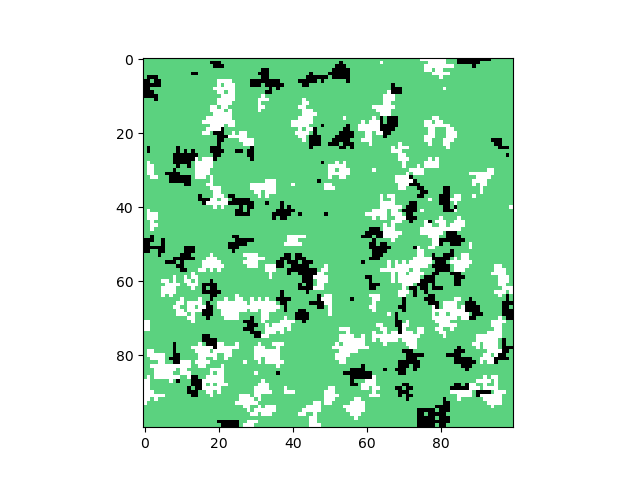

In [87]:
#Attempts to make preddy preddy graphs
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation


##############################################################
fig, ax = plt.subplots()
cmap_custom = ListedColormap(["#FFFFFF", "#5BD27F", "#000000"])
image = ax.imshow(myboard_hash[0][0], cmap=cmap_custom)          
##############################################################

def init():
    image.set_data(myboard_hash[0][0])
    return image, #NOTE: return iterables

def update(frame):
    image.set_data(myboard_hash[frame][0])
    return image, #Note: return iterables

ani = FuncAnimation(
    fig, update, frames=myboard_hash.keys(), init_func=init, blit=True
)

plt.show()

In [ ]:
#Attempts to make preddy preddy graphs
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation


##############################################################
fig, ax = plt.subplots()
cmap_custom = ListedColormap(["#009900", "#FFFFFF", "202020"])
image = ax.imshow(myboard_hash[0][0], cmap=cmap_custom)          
##############################################################

def init():
    image.set_data(myboard_hash[0][0])
    return image, #NOTE: return iterables

def update(frame):
    image.set_data(myboard_hash[frame][0])
    return image, #Note: return iterables

ani = FuncAnimation(
    fig, update, frames=myboard_hash.keys(), init_func=init, blit=True
)

plt.show()